In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.features.cleaning import clean_data, split_X_and_y_data
from src.utils import get_project_root

In [3]:
dir_root = get_project_root()
dir_data = 'data'
filename_data_brain = os.path.join(
    dir_root,
    dir_data, 
    'survival_brain_2000_to_2020_seer_2022_db.csv'
)
data_raw = pd.read_csv(filename_data_brain)

/var/folders/x7/y98cqsdn699czxl0ksdv4x100000gn/T/ipykernel_55548/801828396.py:8: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(filename_data_brain)


In [4]:
data = clean_data(data_raw)

For an initial look, let's just define a list of some of the  columns that look interesting.

## Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest
from scipy import stats

In [6]:
data_train, data_test = train_test_split(
    data, 
    test_size=0.2, 
    random_state=2984, 
    shuffle=True, 
    stratify=data['Vital status recode (study cutoff used)']
)

X_train, y_train = split_X_and_y_data(data_train)
X_test , y_test  = split_X_and_y_data(data_test)

In [7]:
X_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 61061 entries, 36640 to 46191
Data columns (total 128 columns):
 #    Column                                                                 Non-Null Count  Dtype   
---   ------                                                                 --------------  -----   
 0    Age recode with <1 year olds                                           61061 non-null  int64   
 1    Sex                                                                    61061 non-null  category
 2    Year of diagnosis                                                      61061 non-null  int64   
 3    PRCDA 2020                                                             61061 non-null  object  
 4    Race recode (W, B, AI, API)                                            61061 non-null  category
 5    Origin recode NHIA (Hispanic, Non-Hisp)                                61061 non-null  category
 6    Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)           

## Model Training

### Train a very simple two-feature model without a pipeline

In [8]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

In [9]:
X_subset_train = X_train[['Age recode with <1 year olds','Year of diagnosis']]

estimator = CoxnetSurvivalAnalysis(verbose=True, fit_baseline_model=True)
estimator.fit(pd.DataFrame(X_subset_train), y_train.to_records(index=False))

CoxnetSurvivalAnalysis(fit_baseline_model=True, verbose=True)

In [10]:
estimator.score(X_subset_train, y_train.to_records(index=False))

0.7365607149993917

In [11]:
X_to_pred = pd.DataFrame.from_dict(
    {
        1: [20, 2010],
        2: [40, 2005],
        3: [60, 2020],
        4: [80, 2020],
    },
    columns=X_subset_train.columns,
    orient="index",
)
X_to_pred

,Age recode with <1 year olds,Year of diagnosis
1,20,2010
2,40,2005
3,60,2020
4,80,2020


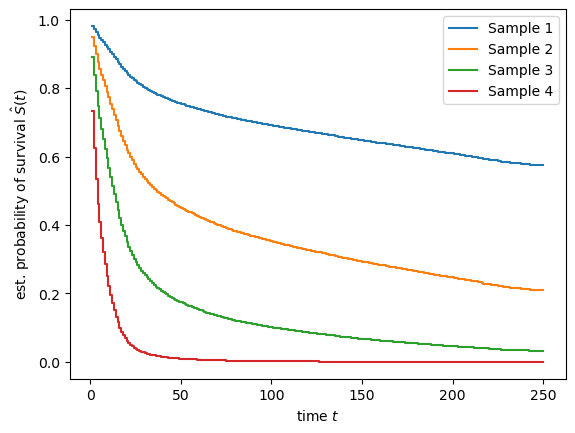

In [12]:
pred_surv = estimator.predict_survival_function(X_to_pred)
time_points = np.arange(1, 251)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points),
             where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

### Pipeline analysis

#### Train a bunch of single-parameter models

In [13]:
def train_single_param_models(X, y, transformers):
    '''
    Trains a series of models, each on only a single feature of the data.
    "transformers" is a list of tuples, each containing (1) the 
    transformer/pipeline for a single column and (2) the name of the column
    (e.g.: `(StandardScaler(), ['Age recode with <1 year olds'])`)
    '''
    models = []
    for i,t in enumerate(transformers):
        col_name = t[1][0]
        print(f'{i+1}/{len(transformers)}: {col_name}')
        column_transformer = make_column_transformer(t, remainder='drop')
        pipeline = make_pipeline(
            column_transformer, 
            CoxnetSurvivalAnalysis(verbose=True, fit_baseline_model=True)
        )
        pipeline.fit(X, y.to_records(index=False))
        models.append(pipeline)
    return models
        

In [14]:
from src.transformers.transformers import DataFrameTransformer

In [15]:
impute_ohe_scale = make_pipeline(
    SimpleImputer(strategy='constant', add_indicator=True).set_output(transform="pandas"), 
    DataFrameTransformer(),
    OneHotEncoder(),
    StandardScaler()
)
impute_mean_scale = make_pipeline(
    SimpleImputer(strategy='mean', add_indicator=True), 
    StandardScaler()
)

single_column_transformers = [
    (impute_ohe_scale, ['Sex']),
    (StandardScaler(), ['Age recode with <1 year olds']),
    (StandardScaler(), ['Year of diagnosis']),
    (impute_ohe_scale, ['Race recode (W, B, AI, API)']),
    (impute_ohe_scale, ['Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)']),
    (impute_ohe_scale, ['Marital status at diagnosis']),
    (impute_mean_scale, ['Median household income inflation adj to 2021 (thousands USD)']),
    (impute_ohe_scale, ['AYA site recode 2020 Revision']),
    (impute_ohe_scale, ['SEER Brain and CNS Recode']),
    (impute_ohe_scale, ['Primary Site - labeled']),
    (impute_ohe_scale, ['Histologic Type ICD-O-3']),
    (impute_ohe_scale, ['Grade Recode (thru 2017)']),
    (impute_ohe_scale, ['Diagnostic Confirmation']),
    (impute_ohe_scale, ['Histology recode - broad groupings']),
    (impute_ohe_scale, ['SEER Combined Summary Stage 2000 (2004-2017)']),
    (impute_mean_scale, ['Months from diagnosis to treatment']),
    (StandardScaler(), ['Combined Tumor Size']),
    (StandardScaler(), ['No tumor found']),
    (StandardScaler(), ['Unknown tumor size']),
    # (, ['']),
]
models = train_single_param_models(X_train, y_train, single_column_transformers)

1/19: Sex
2/19: Age recode with <1 year olds
3/19: Year of diagnosis
4/19: Race recode (W, B, AI, API)
5/19: Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)
6/19: Marital status at diagnosis
7/19: Median household income inflation adj to 2021 (thousands USD)
8/19: AYA site recode 2020 Revision
9/19: SEER Brain and CNS Recode
10/19: Primary Site - labeled
11/19: Histologic Type ICD-O-3
12/19: Grade Recode (thru 2017)
13/19: Diagnostic Confirmation
14/19: Histology recode - broad groupings
15/19: SEER Combined Summary Stage 2000 (2004-2017)
16/19: Months from diagnosis to treatment
17/19: Combined Tumor Size
18/19: No tumor found
19/19: Unknown tumor size


In [16]:
# Results
col_names = [t[1][0] for t in single_column_transformers]
model_scores = [model.score(X_train, y_train.to_records(index=False)) for model in models]
model_scores_ser = pd.Series(model_scores, index=col_names)

In [17]:
model_scores_ser.sort_values(ascending=False)

Age recode with <1 year olds                                     0.733793
Histologic Type ICD-O-3                                          0.670023
AYA site recode 2020 Revision                                    0.663666
SEER Brain and CNS Recode                                        0.649896
Marital status at diagnosis                                      0.585267
Months from diagnosis to treatment                               0.578247
Primary Site - labeled                                           0.557817
SEER Combined Summary Stage 2000 (2004-2017)                     0.543853
Diagnostic Confirmation                                          0.543534
Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)       0.525378
Median household income inflation adj to 2021 (thousands USD)    0.521123
Combined Tumor Size                                              0.516632
Year of diagnosis                                                0.515613
Race recode (W, B, AI, API)           

### Train a small multi-feature model

We use the top 5 features from above.

We do this to test the multi-feature modeling as well as setting up `GridSearchCV`.

In [18]:
column_transformer = make_column_transformer(
    (StandardScaler(), ['Age recode with <1 year olds']),
    (impute_ohe_scale, [
        'Histologic Type ICD-O-3',
        'AYA site recode 2020 Revision', 
        'SEER Brain and CNS Recode',
        'Marital status at diagnosis'
    ]),
    remainder='drop'
)

In [19]:
pipeline = make_pipeline(
    column_transformer, 
    CoxnetSurvivalAnalysis(verbose=True, fit_baseline_model=True)
)

cv_search_dist = {
    'coxnetsurvivalanalysis__l1_ratio': np.linspace(0.8, 1, 5)
}
cv_search = GridSearchCV(
    pipeline, 
    cv_search_dist, 
    cv=3,
    n_jobs=-1
)
cv_search.fit(X_train, y_train.to_records(index=False))

/Users/ajy/miniforge_86/envs/cancer_survival/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ajy/miniforge_86/envs/cancer_survival/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ajy/miniforge_86/envs/cancer_survival/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ajy/miniforge_86/envs/cancer_survival/lib/python3.12/site-packages/sklearn/pipeline.py", line 760, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ajy/miniforge_86

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Age '
                                                                          'recode '
                                                                          'with '
                                                                          '<1 '
                                                                          'year '
                                                                          'olds']),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='constant')),
                                                                                         ('dataframetransformer',
                                                                                          DataFrameTransformer()),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Histologic '
                                                                          'Type '
                                                                          'ICD-O-3',
                                                                          'AYA '
                                                                          'site '
                                                                          'recode '
                                                                          '2020 '
                                                                          'Revision',
                                                                          'SEER '
                                                                          'Brain '
                                                                          'and '
                                                                          'CNS '
                                                                          'Recode',
                                                                          'Marital '
                                                                          'status '
                                                                          'at '
                                                                          'diagnosis'])])),
                                       ('coxnetsurvivalanalysis',
                                        CoxnetSurvivalAnalysis(fit_baseline_model=True,
                                                               verbose=True))]),
             n_jobs=-1,
             param_grid={'coxnetsurvivalanalysis__l1_ratio': array([0.8 , 0.85, 0.9 , 0.95, 1.  ])})

In [20]:
cv_search.score(X_train, y_train.to_records(index=False))

0.7555532957100285

This gives us a very small improvement over the previous best single-parameter model.

In [21]:
cv_search.best_params_

{'coxnetsurvivalanalysis__l1_ratio': 0.8}

It's interesting that `l1_ratio = 0.8` is preferred here. I'm not sure what to make of it. Maybe the model is so simple that we're getting weird behavior? I thought we should expect a value closer to 1. 

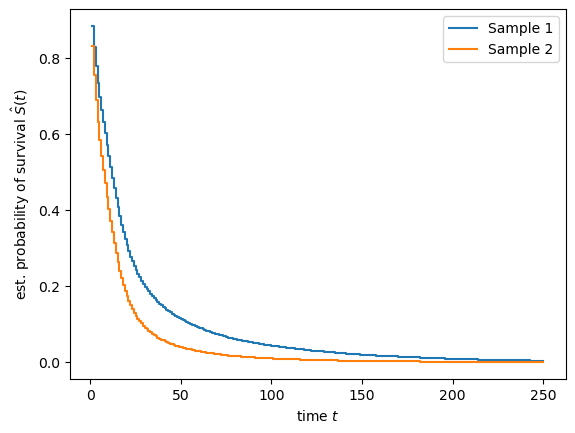

In [22]:
# X_to_pred = pd.DataFrame.from_dict(
#     {
#         1: X_train.iloc[0],
#         2: X_train.iloc[1],
#     },
#     columns=X_train.columns,
#     orient="index",
# )
pred_surv = cv_search.best_estimator_.predict_survival_function(X_train.iloc[0:2])
time_points = np.arange(1, 251)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points),
             where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")